In [2]:
import pandas as pd
import numpy as np
import datetime

year = 2016

# Car specifications
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Load PV and BS data
pv_bs_profile = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\df_pv_bs_240906.csv')

# Assume that the data is for the year 2016
hours_per_year = 8784

results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='H'), 
                       columns=['EV_battery', 'EV_at_home', 'PV_used', 'Grid_used', 'BS_used'])

# Function to generate car availability (home or not) based on the driver profile and trip duration
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    duration_array = np.zeros(hours_per_year)  # Duration of trips each day (hours)
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        day_of_week = i // 24 % 7
        
        if homeoffice and day_of_week in [1, 3, 5]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and day_of_week in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
            duration_array[i+7:i+16] = 9  # 9 hours away for work days
            
        # Random weekend trips
        if day_of_week in [6, 0]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0
                duration_array[i+start_hour:i+start_hour+trip_duration] = trip_duration  # Set trip duration

    return availability, duration_array

# Simulate the EV charging and driving behavior for each hour
def simulate_ev_charging(homeoffice=True):
    # Generate car availability profile with trip duration
    car_availability, trip_durations = generate_car_availability(homeoffice)
    
    # Initial conditions
    ev_battery = max_battery_level
    bs_soc = pv_bs_profile['battery_soc'].iloc[0]  # Start with the initial battery storage state
    
    max_charge_power = 11  # kW

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        
        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check trip type: commuting or random trip
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = other_trips_avg * (trip_durations[hour] > 0)  # Calculate distance based on duration
                
            # Deduct battery consumption for driving based on trip distance
            ev_battery -= trip_distance * car_efficiency
            ev_battery = max(ev_battery, min_battery_level)  # Ensure it doesn't go below min battery level
            
        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_bs_profile['pv_excess'].iloc[hour]
            bs_soc = pv_bs_profile['battery_soc'].iloc[hour]
            pv = pv_bs_profile['pv'].iloc[hour]
            
            # Check the decision flow for charging
            charge_power = min(max_charge_power, max_battery_level - ev_battery)

            if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                charge_power = min(pv_surplus, charge_power)
                ev_battery += charge_power
                pv_used_total += charge_power
            
            elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                grid_contribution = 1.4 - pv_surplus  # Amount from the grid to reach 1.4 kW
                charge_power = min(1.4, charge_power)  # Ensure 1.4 kW total
                ev_battery += charge_power
                pv_used_total += pv_surplus
                grid_used_total += grid_contribution
            
            elif pv < 10 and bs_soc > 1.4:  # Use battery storage if PV low
                bs_available_power = max(0, 10 - pv)
                charge_power = min(bs_available_power, charge_power)
                ev_battery += charge_power
                bs_used_total += charge_power
                bs_soc -= charge_power  # Decrease BS state
                pv_bs_profile['battery_soc'].iloc[hour] = bs_soc  # Update BS SOC in the profile
            
            elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if low
                charge_power = min(1.4, charge_power)
                ev_battery += charge_power
                grid_used_total += charge_power
        
        # Update results
        results.loc[results.index[hour], 'EV_battery'] = ev_battery
        results.loc[results.index[hour], 'EV_at_home'] = car_availability[hour]
        results.loc[results.index[hour], 'PV_used'] = pv_used_total
        results.loc[results.index[hour], 'Grid_used'] = grid_used_total
        results.loc[results.index[hour], 'BS_used'] = bs_used_total

    return results

# Run the simulation
results = simulate_ev_charging()
print(results.head())


C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_25880\40505064.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='H'),
C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_25880\40505064.py:108: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps upda

                    EV_battery EV_at_home PV_used Grid_used BS_used
2016-01-01 00:00:00       57.6        1.0       0         0       0
2016-01-01 01:00:00       57.6        1.0       0         0       0
2016-01-01 02:00:00       57.6        1.0       0         0       0
2016-01-01 03:00:00       57.6        1.0       0         0       0
2016-01-01 04:00:00       57.6        1.0       0         0       0


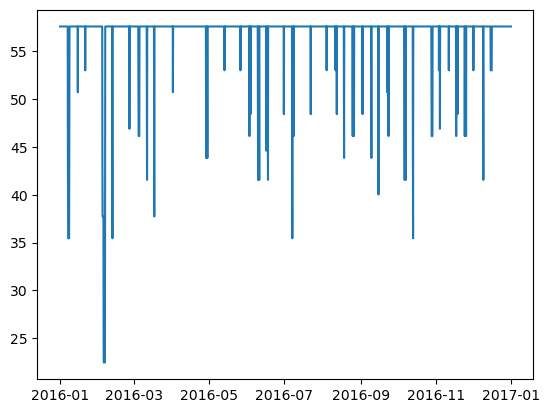

In [3]:
import matplotlib.pyplot as plt
plt.plot(results['EV_battery'])

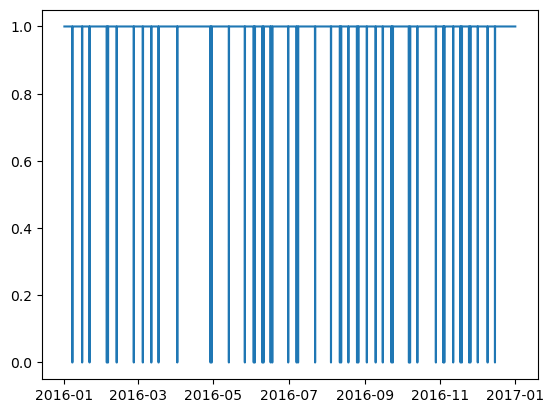

In [4]:
import matplotlib.pyplot as plt
plt.plot(results['EV_at_home'])

In [5]:
import pandas as pd
import numpy as np
import datetime

year = 2016

# Car specifications
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Load PV and BS data
pv_bs_profile = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\df_pv_bs_240906.csv')

# Assume that the data is for the year 2016
hours_per_year = 8784

# Updated to use 'h' for hourly frequency
results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h'), 
                       columns=['EV_battery', 'EV_at_home', 'PV_used', 'Grid_used', 'BS_used'])

# Function to generate car availability (home or not) based on the driver profile and trip duration
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    duration_array = np.zeros(hours_per_year)  # Duration of trips each day (hours)
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        day_of_week = i // 24 % 7
        
        if homeoffice and day_of_week in [1, 3, 5]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and day_of_week in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
            duration_array[i+7:i+16] = 9  # 9 hours away for work days
            
        # Random weekend trips
        if day_of_week in [6, 0]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0
                duration_array[i+start_hour:i+start_hour+trip_duration] = trip_duration  # Set trip duration

    return availability, duration_array

# Simulate the EV charging and driving behavior for each hour
def simulate_ev_charging(homeoffice=True):
    # Generate car availability profile with trip duration
    car_availability, trip_durations = generate_car_availability(homeoffice)
    
    # Initial conditions
    ev_battery = max_battery_level
    bs_soc = pv_bs_profile.loc[0, 'battery_soc']  # Start with the initial battery storage state
    
    max_charge_power = 11  # kW

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        
        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check trip type: commuting or random trip
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = other_trips_avg * (trip_durations[hour] > 0)  # Calculate distance based on duration
                
            # Deduct battery consumption for driving based on trip distance
            ev_battery -= trip_distance * car_efficiency
            ev_battery = max(ev_battery, min_battery_level)  # Ensure it doesn't go below min battery level
            
        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_bs_profile.loc[hour, 'pv_excess']
            bs_soc = pv_bs_profile.loc[hour, 'battery_soc']
            pv = pv_bs_profile.loc[hour, 'pv']
            
            # Check the decision flow for charging
            charge_power = min(max_charge_power, max_battery_level - ev_battery)

            if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                charge_power = min(pv_surplus, charge_power)
                ev_battery += charge_power
                pv_used_total += charge_power
            
            elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                grid_contribution = 1.4 - pv_surplus  # Amount from the grid to reach 1.4 kW
                charge_power = min(1.4, charge_power)  # Ensure 1.4 kW total
                ev_battery += charge_power
                pv_used_total += pv_surplus
                grid_used_total += grid_contribution
            
            elif pv < 10 and bs_soc > 1.4:  # Use battery storage if PV low
                bs_available_power = max(0, 10 - pv)
                charge_power = min(bs_available_power, charge_power)
                ev_battery += charge_power
                bs_used_total += charge_power
                bs_soc -= charge_power  # Decrease BS state
                pv_bs_profile.loc[hour, 'battery_soc'] = bs_soc  # Update BS SOC in the profile
            
            elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if low
                charge_power = min(1.4, charge_power)
                ev_battery += charge_power
                grid_used_total += charge_power
        
        # Update results
        results.loc[results.index[hour], 'EV_battery'] = ev_battery
        results.loc[results.index[hour], 'EV_at_home'] = car_availability[hour]
        results.loc[results.index[hour], 'PV_used'] = pv_used_total
        results.loc[results.index[hour], 'Grid_used'] = grid_used_total
        results.loc[results.index[hour], 'BS_used'] = bs_used_total

    return results

# Run the simulation
results = simulate_ev_charging()
print(results.head())


                    EV_battery EV_at_home PV_used Grid_used BS_used
2016-01-01 00:00:00       57.6        1.0       0         0       0
2016-01-01 01:00:00       57.6        1.0       0         0       0
2016-01-01 02:00:00       57.6        1.0       0         0       0
2016-01-01 03:00:00       57.6        1.0       0         0       0
2016-01-01 04:00:00       57.6        1.0       0         0       0


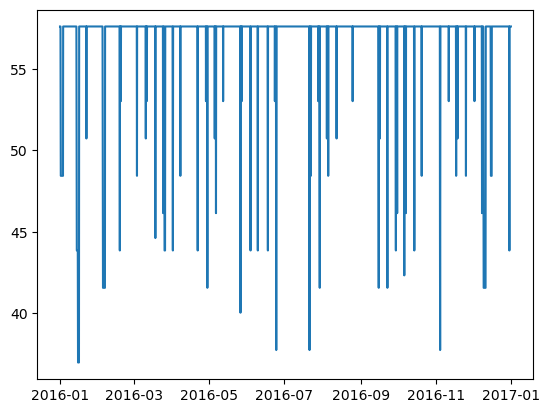

In [6]:
import matplotlib.pyplot as plt
plt.plot(results['EV_battery'])

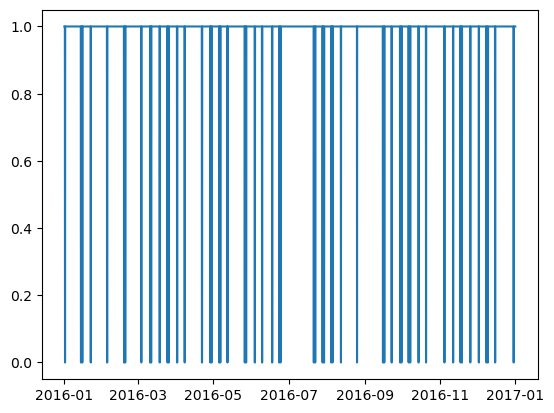

In [7]:
plt.plot(results['EV_at_home'])

In [8]:
import pandas as pd
import numpy as np
import datetime

year = 2016

# Car specifications
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Load PV and BS data
pv_bs_profile = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\df_pv_bs_240906.csv')

# Assume that the data is for the year 2016
hours_per_year = 8784

# Updated to use 'h' for hourly frequency
results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h'), 
                       columns=['EV_battery', 'EV_at_home', 'PV_used', 'Grid_used', 'BS_used'])

# Function to generate car availability (home or not) based on the driver profile and trip duration
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    duration_array = np.zeros(hours_per_year)  # Duration of trips each day (hours)
    
    # Create a DatetimeIndex for the entire year 2016 to get accurate day-of-week information
    date_index = pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h')
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        current_day = date_index[i].dayofweek  # 0=Monday, 6=Sunday
        
        # Determine car availability based on the actual day of the week
        if homeoffice and current_day in [0, 2, 4]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and current_day in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
            duration_array[i+7:i+16] = 9  # 9 hours away for work days
            
        # Random weekend trips
        if current_day in [5, 6]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0
                duration_array[i+start_hour:i+start_hour+trip_duration] = trip_duration  # Set trip duration

    return availability, duration_array

# Simulate the EV charging and driving behavior for each hour
def simulate_ev_charging(homeoffice=True):
    # Generate car availability profile with trip duration
    car_availability, trip_durations = generate_car_availability(homeoffice)
    
    # Initial conditions
    ev_battery = max_battery_level
    bs_soc = pv_bs_profile.loc[0, 'battery_soc']  # Start with the initial battery storage state
    
    max_charge_power = 11  # kW

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        
        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check trip type: commuting or random trip
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = other_trips_avg * (trip_durations[hour] > 0)  # Calculate distance based on duration
                
            # Deduct battery consumption for driving based on trip distance
            ev_battery -= trip_distance * car_efficiency
            ev_battery = max(ev_battery, min_battery_level)  # Ensure it doesn't go below min battery level
            
        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_bs_profile.loc[hour, 'pv_excess']
            bs_soc = pv_bs_profile.loc[hour, 'battery_soc']
            pv = pv_bs_profile.loc[hour, 'pv']
            
            # Check the decision flow for charging
            charge_power = min(max_charge_power, max_battery_level - ev_battery)

            if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                charge_power = min(pv_surplus, charge_power)
                ev_battery += charge_power
                pv_used_total += charge_power
            
            elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                grid_contribution = 1.4 - pv_surplus  # Amount from the grid to reach 1.4 kW
                charge_power = min(1.4, charge_power)  # Ensure 1.4 kW total
                ev_battery += charge_power
                pv_used_total += pv_surplus
                grid_used_total += grid_contribution
            
            elif pv < 10 and bs_soc > 1.4:  # Use battery storage if PV low
                bs_available_power = max(0, 10 - pv)
                charge_power = min(bs_available_power, charge_power)
                ev_battery += charge_power
                bs_used_total += charge_power
                bs_soc -= charge_power  # Decrease BS state
                pv_bs_profile.loc[hour, 'battery_soc'] = bs_soc  # Update BS SOC in the profile
            
            elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if low
                charge_power = min(1.4, charge_power)
                ev_battery += charge_power
                grid_used_total += charge_power
        
        # Update results
        results.loc[results.index[hour], 'EV_battery'] = ev_battery
        results.loc[results.index[hour], 'EV_at_home'] = car_availability[hour]
        results.loc[results.index[hour], 'PV_used'] = pv_used_total
        results.loc[results.index[hour], 'Grid_used'] = grid_used_total
        results.loc[results.index[hour], 'BS_used'] = bs_used_total

    return results

# Run the simulation
results = simulate_ev_charging()
results


,EV_battery,EV_at_home,PV_used,Grid_used,BS_used
2016-01-01 00:00:00,57.6,1.0,0,0,0
2016-01-01 01:00:00,57.6,1.0,0,0,0
2016-01-01 02:00:00,57.6,1.0,0,0,0
2016-01-01 03:00:00,57.6,1.0,0,0,0
2016-01-01 04:00:00,57.6,1.0,0,0,0
...,...,...,...,...,...
2016-12-31 19:00:00,57.6,1.0,0,0,0
2016-12-31 20:00:00,57.6,1.0,0,0,0
2016-12-31 21:00:00,57.6,1.0,0,0,0
2016-12-31 22:00:00,57.6,1.0,0,0,0


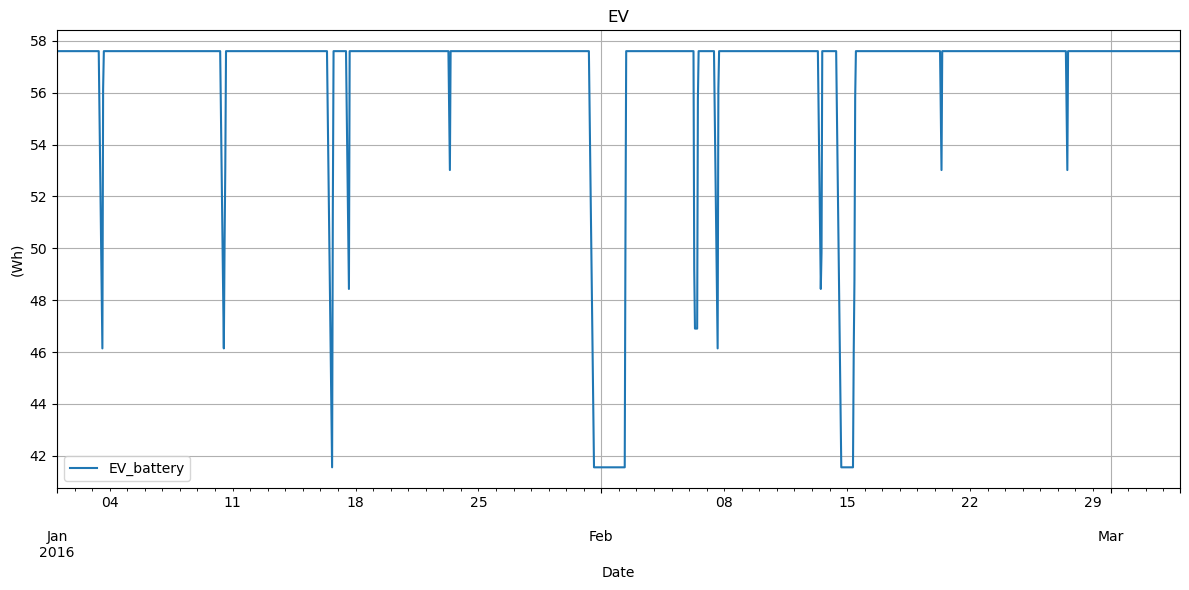

In [9]:
import matplotlib.pyplot as plt
# plt.plot(results['EV_battery'])
# 
tag = results.loc['2016-01-01 00:00:00':'2016-03-04 23:00:00', ['EV_battery']]
tag_plot = tag.plot(figsize=(12, 6))
tag_plot.set_xlabel('Date')
tag_plot.set_ylabel('(Wh)')
tag_plot.set_title('EV')
plt.grid(True)
plt.tight_layout()
plt.show()

                  

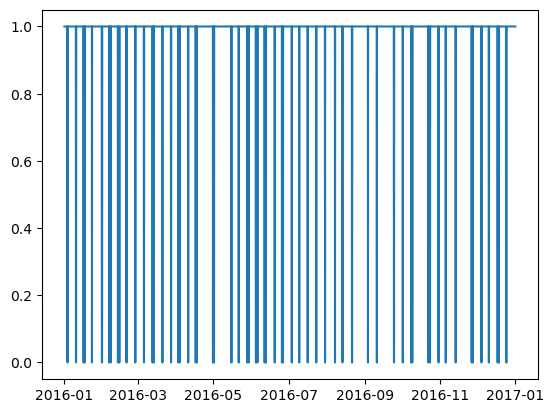

In [10]:
plt.plot(results['EV_at_home'])


In [11]:
import pandas as pd
import numpy as np
import datetime

year = 2016

# Car specifications
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Load PV and BS data
pv_bs_profile = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\df_pv_bs_240906.csv')

# Assume that the data is for the year 2016
hours_per_year = 8784

# Updated to use 'h' for hourly frequency
results = pd.DataFrame(index=pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h'), 
                       columns=['EV_battery', 'EV_at_home', 'PV_used', 'Grid_used', 'BS_used', 'Energy_used_total'])

# Function to generate car availability (home or not) based on the driver profile and trip duration
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    duration_array = np.zeros(hours_per_year)  # Duration of trips each day (hours)
    
    # Create a DatetimeIndex for the entire year 2016 to get accurate day-of-week information
    date_index = pd.date_range(start=f'{year}-01-01', periods=hours_per_year, freq='h')
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        current_day = date_index[i].dayofweek  # 0=Monday, 6=Sunday
        
        # Determine car availability based on the actual day of the week
        if homeoffice and current_day in [0, 2, 4]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and current_day in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
            duration_array[i+7:i+16] = 9  # 9 hours away for work days
            
        # Random weekend trips
        if current_day in [5, 6]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0
                duration_array[i+start_hour:i+start_hour+trip_duration] = trip_duration  # Set trip duration

    return availability, duration_array

# Simulate the EV charging and driving behavior for each hour
def simulate_ev_charging(homeoffice=True):
    # Generate car availability profile with trip duration
    car_availability, trip_durations = generate_car_availability(homeoffice)
    
    # Initial conditions
    ev_battery = max_battery_level
    bs_soc = pv_bs_profile.loc[0, 'battery_soc']  # Start with the initial battery storage state
    
    max_charge_power = 11  # kW

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        trip_distance = 0
        
        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check trip type: commuting or random trip
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = other_trips_avg * (trip_durations[hour] > 0)  # Calculate distance based on duration
                
            # Deduct battery consumption for driving based on trip distance
            ev_battery -= trip_distance * car_efficiency
            ev_battery = max(ev_battery, min_battery_level)  # Ensure it doesn't go below min battery level
            
        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_bs_profile.loc[hour, 'pv_excess']
            bs_soc = pv_bs_profile.loc[hour, 'battery_soc']
            pv = pv_bs_profile.loc[hour, 'pv']
            
            # Check the decision flow for charging
            charge_power = min(max_charge_power, max_battery_level - ev_battery)

            if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                charge_power = min(pv_surplus, charge_power)
                ev_battery += charge_power
                pv_used_total += charge_power
            
            elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                grid_contribution = 1.4 - pv_surplus  # Amount from the grid to reach 1.4 kW
                charge_power = min(1.4, charge_power)  # Ensure 1.4 kW total
                ev_battery += charge_power
                pv_used_total += pv_surplus
                grid_used_total += grid_contribution
            
            elif pv < 10 and bs_soc > 1.4:  # Use battery storage if PV low
                bs_available_power = max(0, 10 - pv)
                charge_power = min(bs_available_power, charge_power)
                ev_battery += charge_power
                bs_used_total += charge_power
                bs_soc -= charge_power  # Decrease BS state
                pv_bs_profile.loc[hour, 'battery_soc'] = bs_soc  # Update BS SOC in the profile
            
            elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if low
                charge_power = min(1.4, charge_power)
                ev_battery += charge_power
                grid_used_total += charge_power
        
        # Calculate total energy used for charging the EV this hour
        energy_used_total = pv_used_total + grid_used_total + bs_used_total
        
        # Update results
        results.loc[results.index[hour], 'EV_battery'] = ev_battery
        results.loc[results.index[hour], 'EV_at_home'] = car_availability[hour]
        results.loc[results.index[hour], 'PV_used'] = pv_used_total
        results.loc[results.index[hour], 'Grid_used'] = grid_used_total
        results.loc[results.index[hour], 'BS_used'] = bs_used_total
        results.loc[results.index[hour], 'Energy_used_total'] = energy_used_total
        results.loc[results.index[hour], 'Trip_distance'] = trip_distance

    return results

# Run the simulation
results = simulate_ev_charging()
results


,EV_battery,EV_at_home,PV_used,Grid_used,BS_used,Energy_used_total,Trip_distance
2016-01-01 00:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 01:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 02:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 03:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 04:00:00,57.6,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...
2016-12-31 19:00:00,43.848,1.0,0,0,0,0,0.0
2016-12-31 20:00:00,43.848,1.0,0,0,0,0,0.0
2016-12-31 21:00:00,43.848,1.0,0,0,0,0,0.0
2016-12-31 22:00:00,43.848,1.0,0,0,0,0,0.0


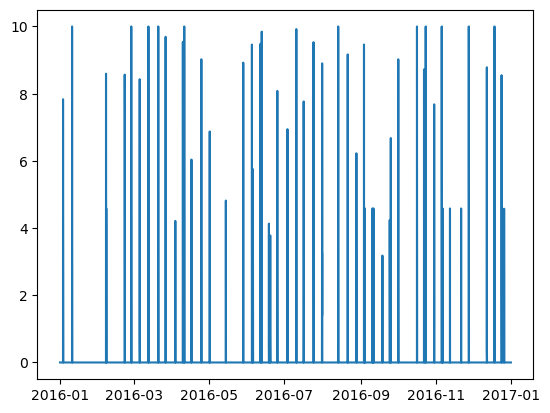

In [12]:
plt.plot(results['Energy_used_total'])

In [13]:
ev_total = sum(results['Energy_used_total'])
ev_total

635.6480000000001

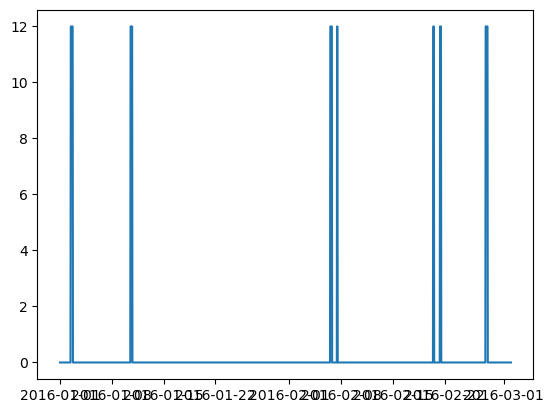

In [14]:
plt.plot(results.loc['2016-01-01 00:00:00':'2016-03-01 23:00:00',['Trip_distance']])

In [15]:
results_nho = simulate_ev_charging(homeoffice=False)
results_nho

,EV_battery,EV_at_home,PV_used,Grid_used,BS_used,Energy_used_total,Trip_distance
2016-01-01 00:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 01:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 02:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 03:00:00,57.6,1.0,0,0,0,0,0.0
2016-01-01 04:00:00,57.6,1.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...
2016-12-31 19:00:00,41.556,1.0,0,0,0,0,0.0
2016-12-31 20:00:00,41.556,1.0,0,0,0,0,0.0
2016-12-31 21:00:00,41.556,1.0,0,0,0,0,0.0
2016-12-31 22:00:00,41.556,1.0,0,0,0,0,0.0


In [16]:
ev_total_nho = sum(results_nho['Energy_used_total'])
ev_total_nho

7295.654999999995

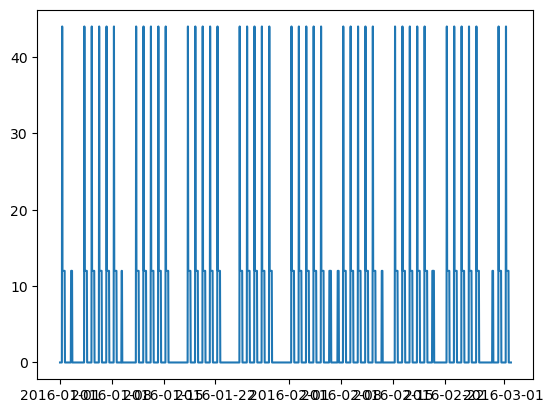

In [17]:
plt.plot(results_nho.loc['2016-01-01 00:00:00':'2016-03-01 23:00:00',['Trip_distance']])

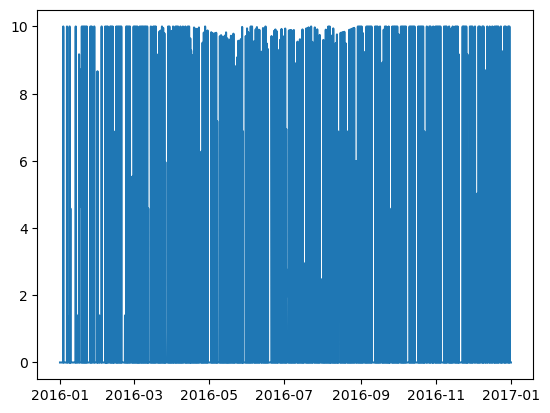

In [18]:
plt.plot(results_nho['Energy_used_total'])

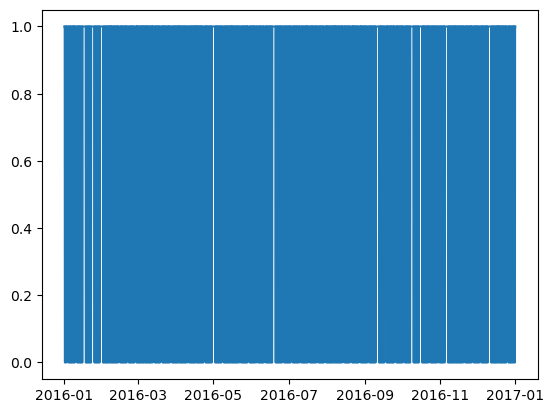

In [19]:
plt.plot(results_nho['EV_at_home'])